Цели и Задачи: проанализиолать данные и выполнить предобработку 


In [434]:
#импортирование библиотек 
import datetime
import math
from collections import defaultdict

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from itertools import combinations
from scipy.stats import ttest_ind, norm
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

%matplotlib inline




#functions 
def get_boxplot(column):
    """
    Отрисовка распределения, по которой можно оценить влияние категориальных столбцов на target переменную
    """
    
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='fam_rel', 
                data=smath.loc[smath.loc[:, column].isin(smath.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title(f'Boxplot for {column}')
    plt.show()
    

def get_dist(column):
    """
    Отрисовка распределения для оценки выбросов для числовых столбцов
    """
    
    data = smath[column]
    fig = plt.figure(figsize=(14,4), constrained_layout=True)
    gs = GridSpec(1, 5, figure=fig)
    
    ax1 = fig.add_subplot(gs[0, :3])
    ax2 = fig.add_subplot(gs[0, 3:])
    
    sns.distplot(data, rug=True, ax=ax1)
    ax1.set_title(f'Распределения для {column}')
    
    sns.boxplot(data, orient='v', ax=ax2)
    ax1.set_title(f'Боксплот для {column}')
    plt.show()

    
def get_stat_dif(column):
    """
    Tеста Стьюдента для оценки статистического влияния категориальных переменных на target переменную
    Взято с курса по DS
    """
    
    cols = smath.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(smath.loc[smath.loc[:, column] == comb[0], 'score'], 
                        smath.loc[smath.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return column
    
    
class outliers():
    """
    Класс для агрегации значений выбросов и их кол-ва разными методами
    """
    
    def __init__(self):
        self.data = None
        self.findings = {}
        
    def __del__(self):
        pass
        
    def fit(self, data):
        if data.isna().sum() != 0:
            raise Exception('В данных есть пропуски')
        self.data = data.values    
        
    
    def z_score(self, threshold):
        if not threshold and not type(threshold) is int:
            raise Exception('Threshold должен быть числом')
        elif self.data is None:
            raise Exception('Сначала добавьте данные')
            
        mean = np.mean(self.data)
        std = np.std(self.data)
        z_scores = [(x - mean) / std for x in self.data]
        self.findings['z-score'] = np.argwhere(np.abs(z_scores) > threshold)
    
    def iqr(self):
        if self.data is None:
            raise Exception('Сначала добавьте данные')
        
        quartile_1, quartile_3 = np.percentile(self.data, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        self.findings['iqr'] = np.argwhere((self.data > upper_bound) | (self.data < lower_bound))
    
    def search_by_dist(self, proba):
        if not proba and not type(proba) is float and proba < 0 and proba > 1:
            raise Exception('Неправильная вероятность')
        elif self.data is None:
            raise Exception('Сначала добавьте данные')
            
        mu, sigma = (np.mean(self.data, axis=0), np.cov(self.data.T))
        distribution = norm(mu, sigma)
        probas = distribution.pdf(self.data)
        self.findings['dist'] = np.argwhere(probas < proba)
        
    def dbscan(self, params):
        if not type(params['eps']) is float and not type(params['min_samples']) is int:
            raise Exception('Неправильные параметры')
                                                               
        data = self.data.reshape(-1, 1)
        db = DBSCAN(eps=params['eps'], min_samples=params['min_samples']).fit(data)
        
        self.findings['dbscan'] = np.argwhere(db.labels_ == -1)
            
    def find_all(self, params):
        if self.data is None:
            raise Exception('Сначала добавьте данные')
        elif (set(['z_threshold', 'kde_proba', 'dbscan']) - params.keys())\
            and (set(['eps', 'min_samples']) - params['dbscan'].keys()):
            raise Exception('Неправильные параметры')
        
        self.iqr()
        self.z_score(params['z_threshold'])
        self.search_by_dist(params['kde_proba'])
        self.dbscan(params['dbscan'])
        
        return self.findings

In [435]:
#Загрузка dataseta и начальный визуальный анализ
path = './data/'
smath = pd.read_csv(f'{path}stud_math.csv')
#Меняю название колонок для удобства и читабельности 
smath.columns = ['school', 'sex', 'age', 'address', 'fam_size', 'p_status', 'm_edu', 'f_edu',
                 'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                 'failures', 'school_sup', 'fam_sup', 'paid', 'activities', 'nursery',
                 'studytime_gran', 'higher', 'internet', 'romantic', 'fam_rel',
                 'freetime', 'go_out', 'health', 'absences', 'score']

smath.drop(['studytime_gran'], axis=1, inplace=True)
print(f'Кол-во строк: {smath.shape[0]}, кол-во столбцов: {smath.shape[1]}')
print(f'Кол-во пропусков в датасете: {smath.isna().any().sum()}')

Кол-во строк: 395, кол-во столбцов: 29
Кол-во пропусков в датасете: 26


Как видно из строк выше, датасет достатачно маленький, но имеет большое кол-во признаков, что может плохо повлият на успешность модели.
Также во всем датасете всего 27 колонок с пропусками из 30! 
В датасете 13 числовых и 17 категориальных признаков
Наконец, можно заметить, что в датасете много категориальных признаков, часть из которых - yes или no, что можно легко конвертировать в 0 или 1

In [436]:
# school — аббревиатура школы, в которой учится ученик
# sex — пол ученика ('F' - женский, 'M' - мужской)
# age — возраст ученика (от 15 до 22)
# address — тип адреса ученика ('U' - городской, 'R' - за городом)
# famsize — размер семьи('LE3' <= 3, 'GT3' >3)
# Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
# Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
# guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
# traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
# studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
# failures — количество внеучебных неудач (n, если 1<=n<3, иначе 0)
# schoolsup — дополнительная образовательная поддержка (yes или no)
# famsup — семейная образовательная поддержка (yes или no)
# paid — дополнительные платные занятия по математике (yes или no)
# activities — дополнительные внеучебные занятия (yes или no)
# nursery — посещал детский сад (yes или no)
# higher — хочет получить высшее образование (yes или no)
# internet — наличие интернета дома (yes или no)
# romantic — в романтических отношениях (yes или no)
# famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
# freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
# goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
# health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
# absences — количество пропущенных занятий
# score — баллы по госэкзамену по математике (target)

smath.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   age         395 non-null    int64  
 3   address     378 non-null    object 
 4   fam_size    368 non-null    object 
 5   p_status    350 non-null    object 
 6   m_edu       392 non-null    float64
 7   f_edu       371 non-null    float64
 8   m_job       376 non-null    object 
 9   f_job       359 non-null    object 
 10  reason      378 non-null    object 
 11  guardian    364 non-null    object 
 12  traveltime  367 non-null    float64
 13  studytime   388 non-null    float64
 14  failures    373 non-null    float64
 15  school_sup  386 non-null    object 
 16  fam_sup     356 non-null    object 
 17  paid        355 non-null    object 
 18  activities  381 non-null    object 
 19  nursery     379 non-null    o

In [437]:
smath.head(10)

,school,sex,age,address,fam_size,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,school_sup,fam_sup,paid,activities,nursery,higher,internet,romantic,fam_rel,freetime,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


# Разбереемся с пропусками, так как 27 колонок из 30 имеют пропуски, мы не можем просто так их всех выкинуть

In [438]:
smath.isna().sum()

school         0
sex            0
age            0
address       17
fam_size      27
p_status      45
m_edu          3
f_edu         24
m_job         19
f_job         36
reason        17
guardian      31
traveltime    28
studytime      7
failures      22
school_sup     9
fam_sup       39
paid          40
activities    14
nursery       16
higher        20
internet      34
romantic      31
fam_rel       27
freetime      11
go_out         8
health        15
absences      12
score          6
dtype: int64

In [439]:
#Заполнение пропусков путем использования sklearn.impute.SimpleImputer
from sklearn.impute import SimpleImputer

imp_median = SimpleImputer(missing_values=np.nan, strategy='median') #Числовые столбцы методом median
imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #Категориальные столбцы методом most_frequent

col_by_type = {'num': [], 'cat': []}
for column in smath.columns:
    if smath[column].dtypes == 'object':
        col_by_type['cat'].append(column)
    elif smath[column].dtypes == 'float64' or 'int64':
            col_by_type['num'].append(column)
            
to_fill = {k: [v for v in ls if smath[v].isna().sum() != 0] for k, ls in col_by_type.items()} 


imp_median.fit(X = smath[to_fill['num']])
smath[to_fill['num']] = pd.DataFrame(data=imp_median.transform(smath[to_fill['num']]), 
                                              columns=to_fill['num'])

imp_most_frequent.fit(X = smath[to_fill['cat']])
smath[to_fill['cat']] = pd.DataFrame(data=imp_most_frequent.transform(smath[to_fill['cat']]), 
                                              columns=to_fill['cat'])

In [440]:
smath.isna().sum()

school        0
sex           0
age           0
address       0
fam_size      0
p_status      0
m_edu         0
f_edu         0
m_job         0
f_job         0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
school_sup    0
fam_sup       0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
fam_rel       0
freetime      0
go_out        0
health        0
absences      0
score         0
dtype: int64

# Посмотрим на распределения

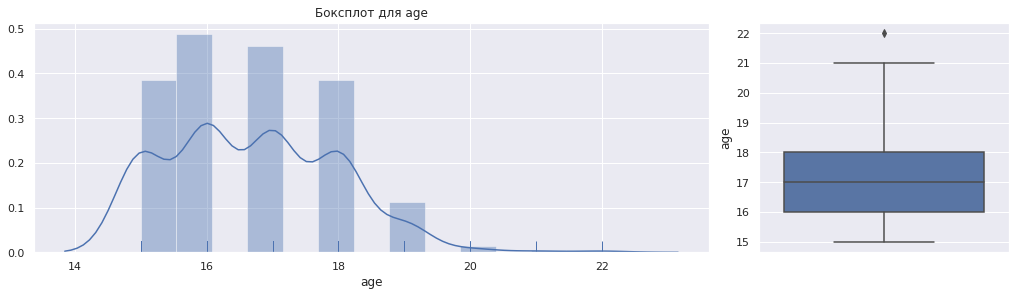

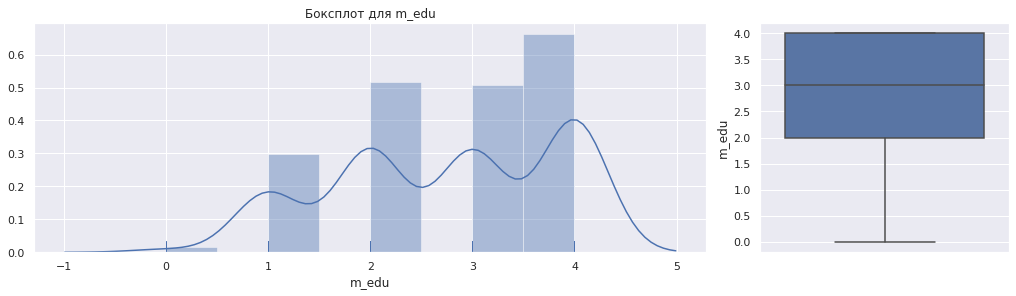

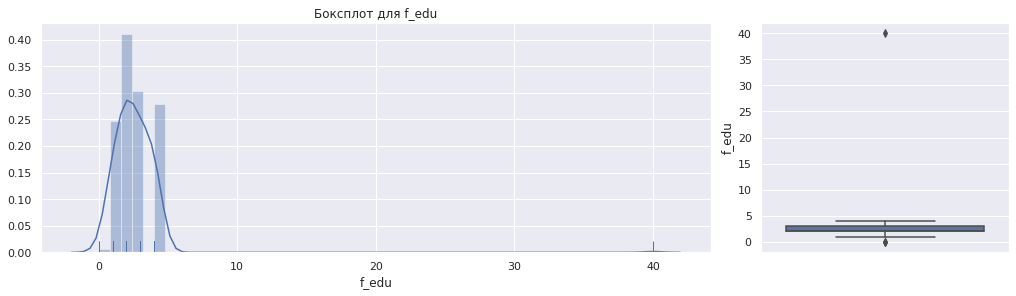

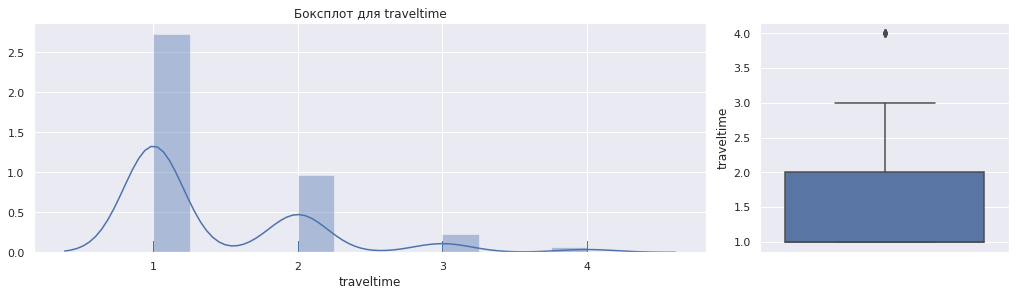

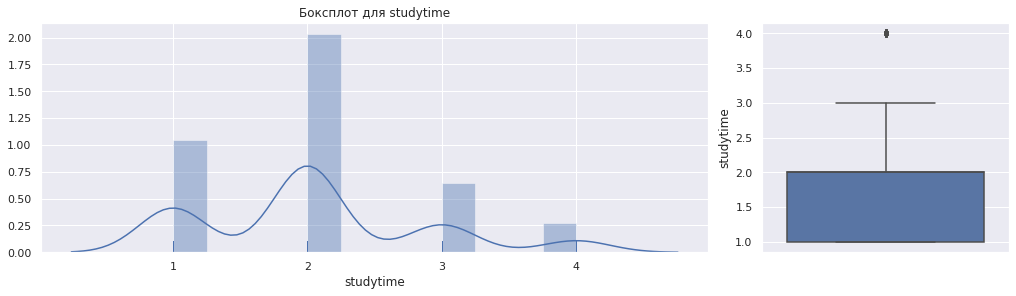

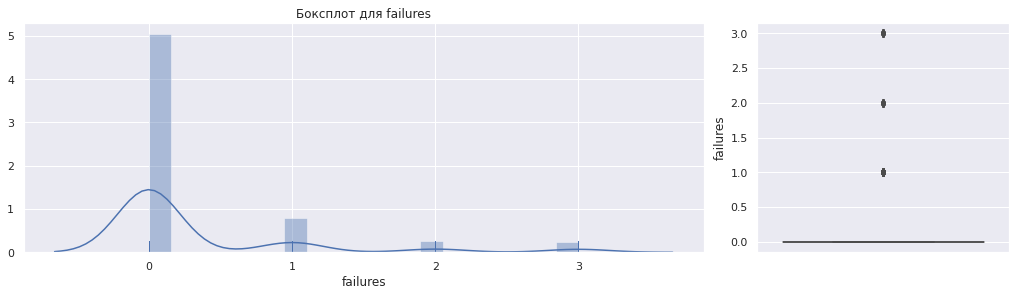

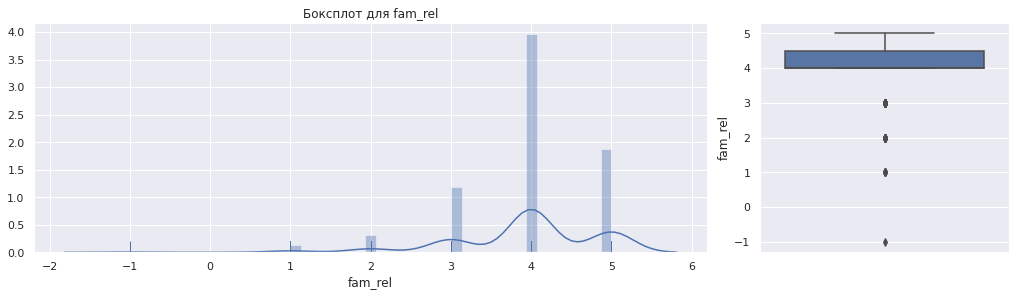

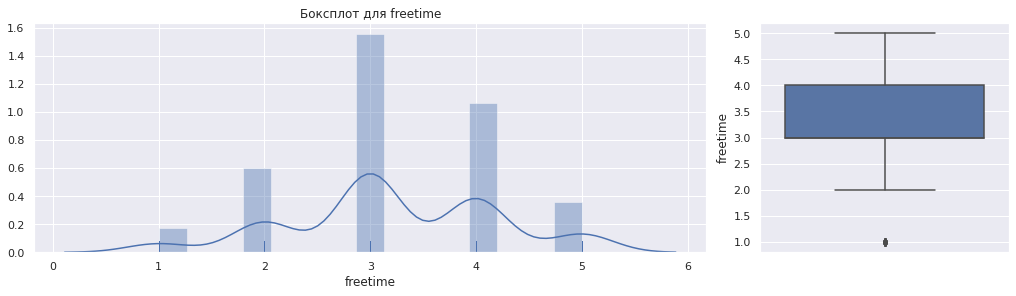

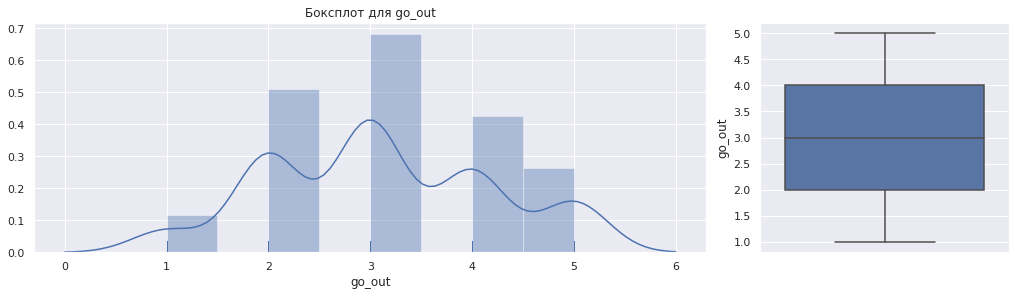

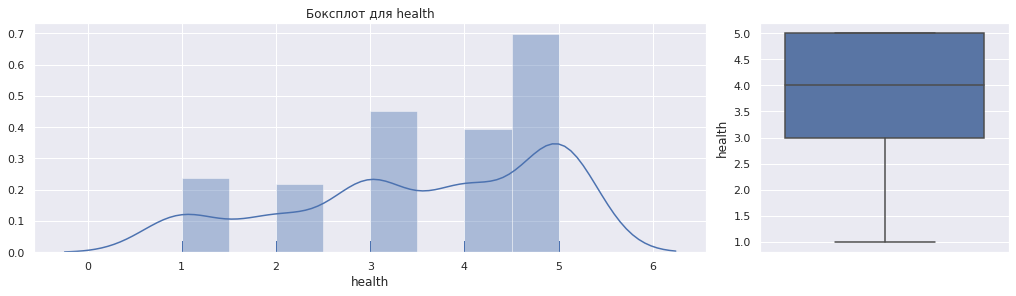

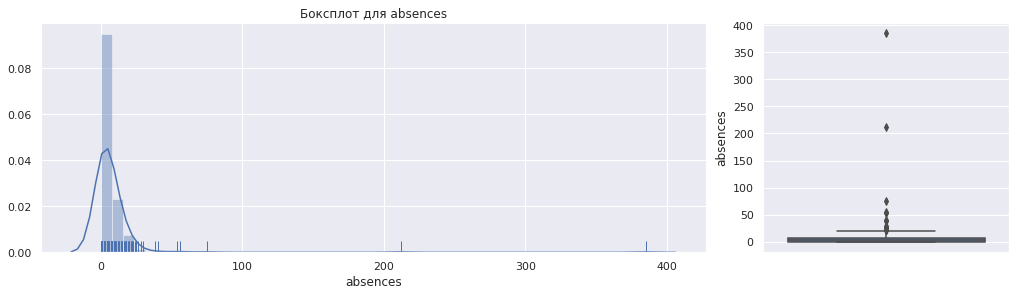

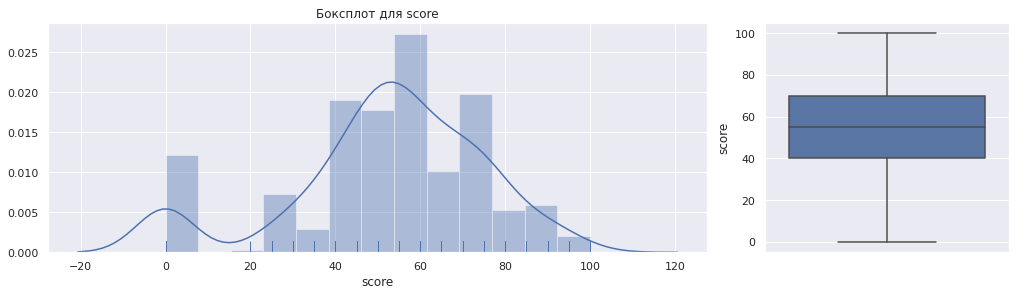

In [441]:
for column in col_by_type['num']:
    get_dist(column)

In [442]:
kek = outliers()
params = {'z_threshold': 3, 'kde_proba': 0.0005, 'dbscan': {'eps': 0.5, 'min_samples': 3}}

type(params['dbscan']['eps']) not in ['int', 'float'] and type(params['dbscan']['min_samples']) != 'int'

for column in col_by_type['num']:
    kek.fit(smath[column])
    result = kek.find_all(params)
    
    values = {k: [smath[column][v[0]] for v in ls] for k, ls in result.items()}
    lens = {k: len(v) for k, v in result.items()}
    
    print(f'\nВыбросы для {column}')
    print(f'Кол-во выбросов: {lens}')
    print(f'Значения: {values}')
        
    

smath.drop(index=smath[smath.age == 22].index, inplace=True) # выбросим строчку где возраст равен 22
smath.at[smath[smath.f_edu == 40.0].index, 'f_edu'] = 4.0 # изменим значение 40.0 в столбце f_edu на 4.0, так как это опечатка
smath.drop(index=smath[smath.traveltime == 4.0].index, inplace=True) # выбросим строчку где время до школы равно 3
smath.drop(index=smath[smath.failures == 3.0].index, inplace=True) # выбросим строчку где неудачи равны 3
smath.drop(index=smath[(smath.fam_rel == 1.0) | (smath.fam_rel == -1.0)].index, inplace=True) # выбросим строчку где отношения с семьей равны 1
smath.drop(index=smath[(smath.absences == 385.0) | (smath.absences == 212.0)].index, inplace=True) # удаление явных выбросов


Выбросы для age
Кол-во выбросов: {'iqr': 1, 'z-score': 2, 'dist': 0, 'dbscan': 2}
Значения: {'iqr': [22], 'z-score': [22, 21], 'dist': [], 'dbscan': [22, 21]}

Выбросы для m_edu
Кол-во выбросов: {'iqr': 0, 'z-score': 0, 'dist': 0, 'dbscan': 0}
Значения: {'iqr': [], 'z-score': [], 'dist': [], 'dbscan': []}

Выбросы для f_edu
Кол-во выбросов: {'iqr': 3, 'z-score': 1, 'dist': 1, 'dbscan': 3}
Значения: {'iqr': [40.0, 0.0, 0.0], 'z-score': [40.0], 'dist': [40.0], 'dbscan': [40.0, 0.0, 0.0]}

Выбросы для traveltime
Кол-во выбросов: {'iqr': 7, 'z-score': 7, 'dist': 7, 'dbscan': 0}
Значения: {'iqr': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'z-score': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'dist': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'dbscan': []}

Выбросы для studytime
Кол-во выбросов: {'iqr': 27, 'z-score': 0, 'dist': 0, 'dbscan': 0}
Значения: {'iqr': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'z-score': 

# Анализ нормативных переменных

In [443]:
for column in col_by_type['cat']:
    print(smath[column].value_counts())

GP    326
MS     40
Name: school, dtype: int64
F    194
M    172
Name: sex, dtype: int64
U    289
R     77
Name: address, dtype: int64
GT3    266
LE3    100
Name: fam_size, dtype: int64
T    333
A     33
Name: p_status, dtype: int64
other       141
services     88
at_home      53
teacher      53
health       31
Name: m_job, dtype: int64
other       216
services     92
teacher      27
at_home      16
health       15
Name: f_job, dtype: int64
course        141
reputation    100
home           95
other          30
Name: reason, dtype: int64
mother    257
father     83
other      26
Name: guardian, dtype: int64
no     320
yes     46
Name: school_sup, dtype: int64
yes    240
no     126
Name: fam_sup, dtype: int64
no     218
yes    148
Name: paid, dtype: int64
yes    198
no     168
Name: activities, dtype: int64
yes    295
no      71
Name: nursery, dtype: int64
yes    352
no      14
Name: higher, dtype: int64
yes    316
no      50
Name: internet, dtype: int64
no     253
yes    113
Name: roma

Уникальных значений достатачно мало, поэтому их можно преобразовать в dummy без дополнительной обработки

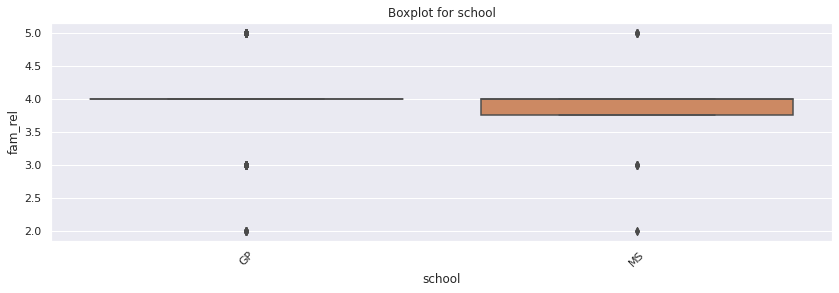

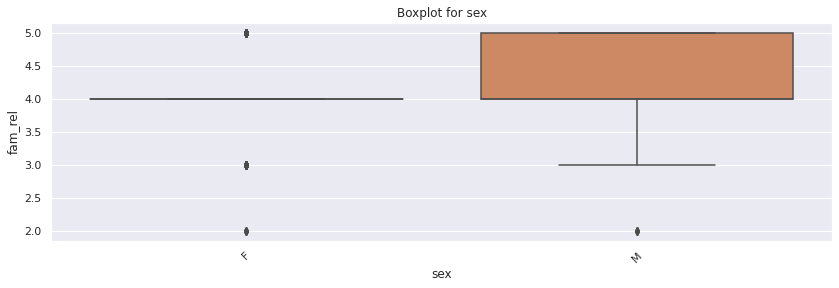

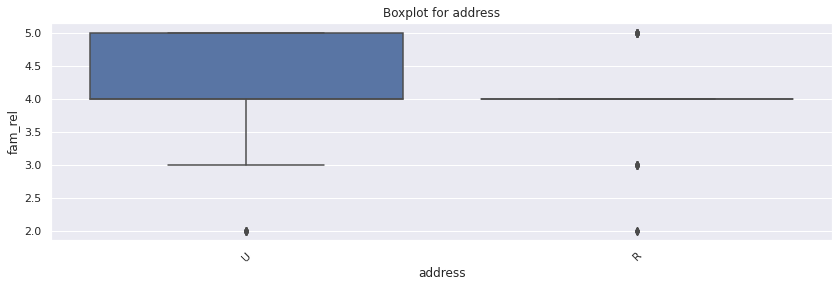

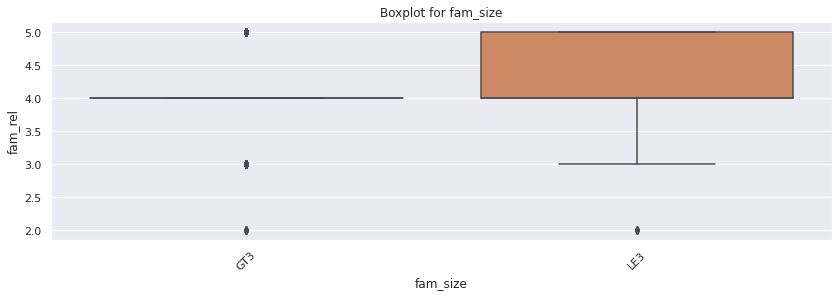

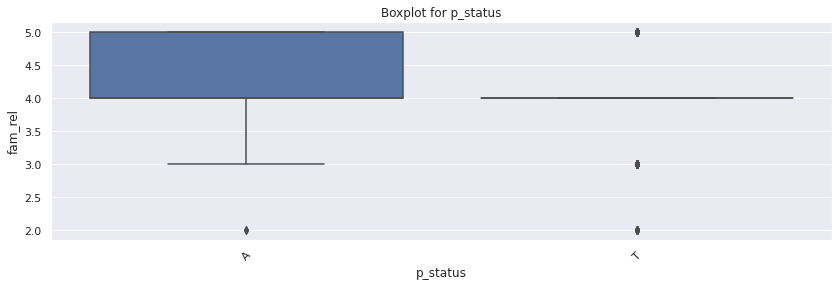

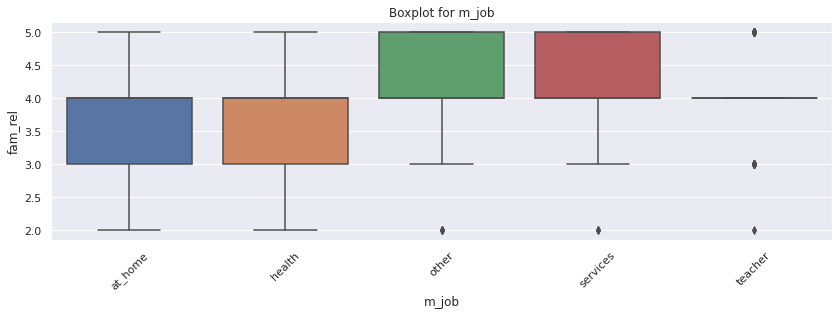

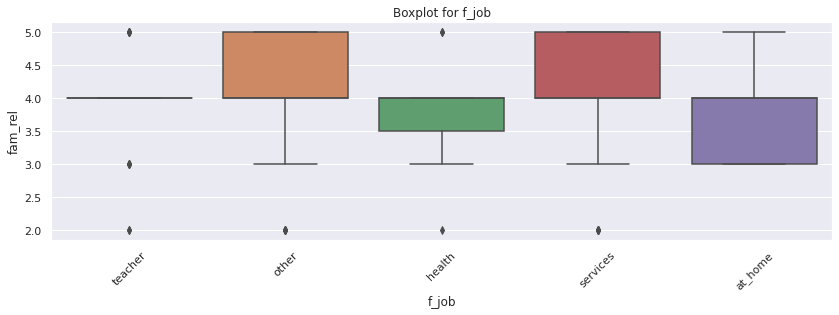

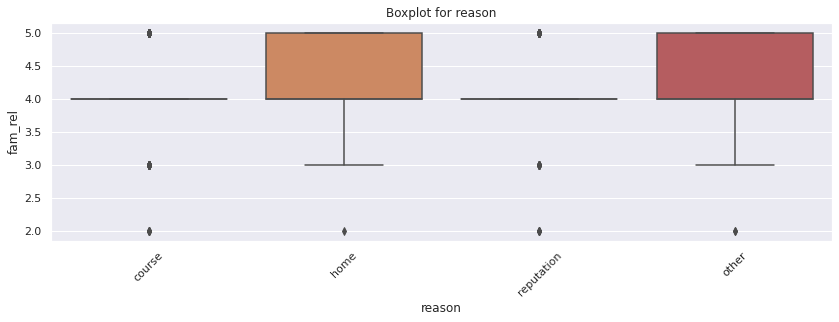

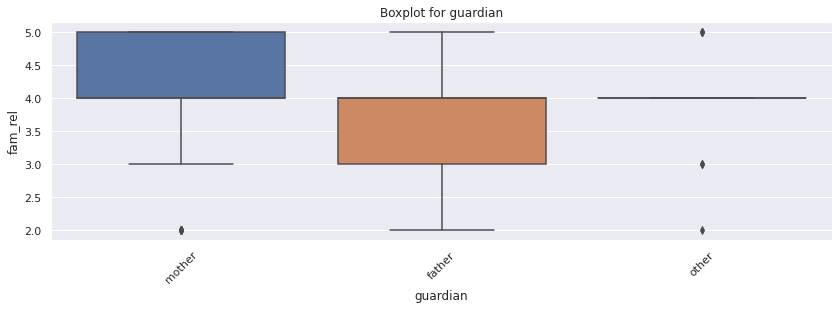

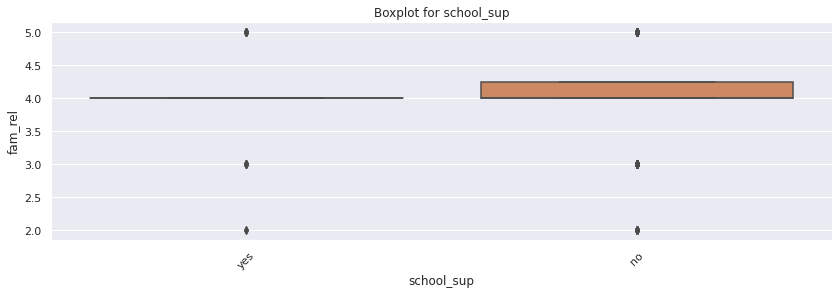

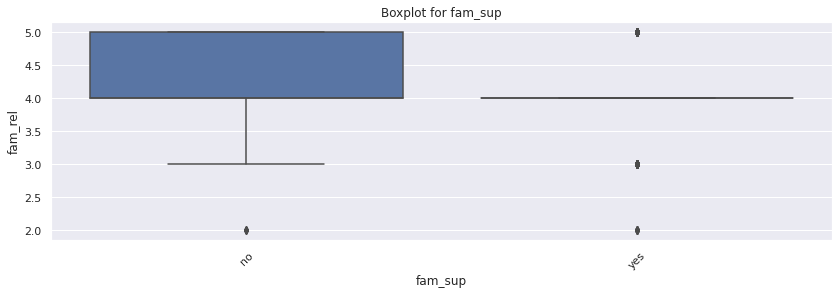

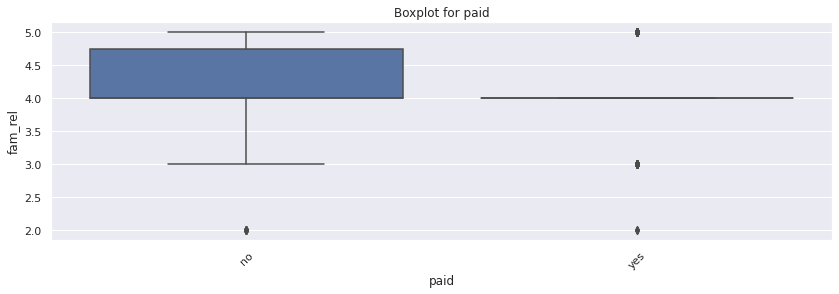

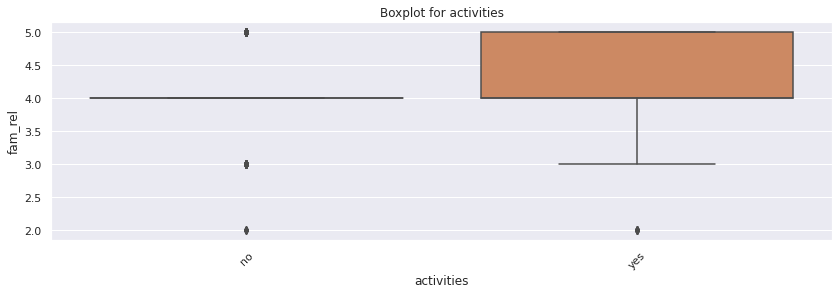

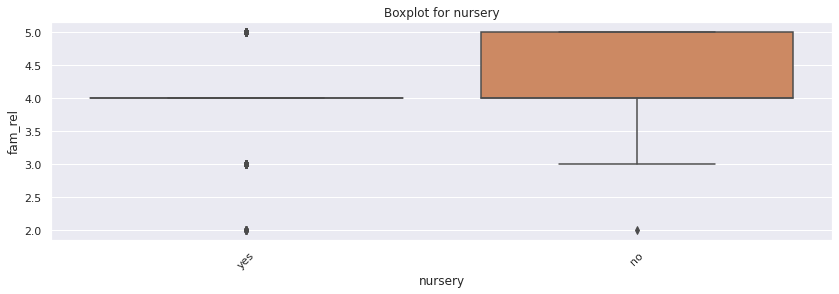

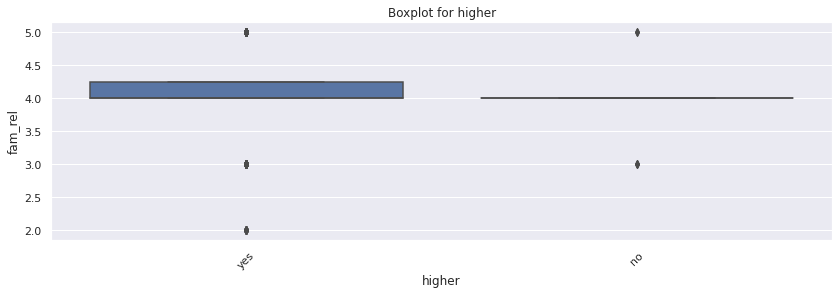

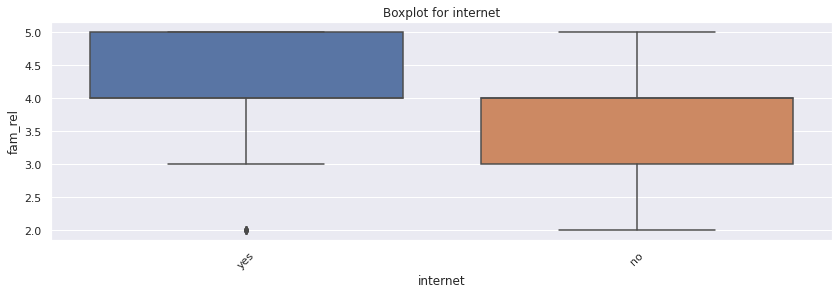

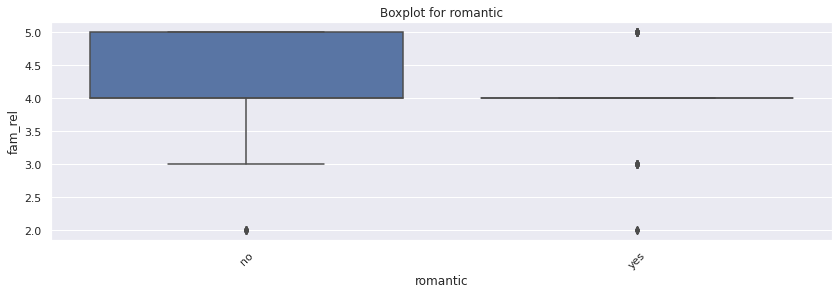

In [444]:
for col in col_by_type['cat']:
    get_boxplot(col)

In [445]:
columns_to_take = []

for col in col_by_type['cat']:
    columns_to_take.append(get_stat_dif(col))

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки m_job
Найдены статистически значимые различия для колонки school_sup
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [446]:
columns_to_take = list(filter(lambda x: x, columns_to_take))
smath.drop(columns=list(set(col_by_type['cat']) - set(columns_to_take)), inplace=True)

# Преобразуем столбцы со значениями yes и no в 1 и 0
coll_to_change = [k for k in columns_to_take if smath[k].str.contains('yes|no', regex=True).all()]
for column in coll_to_change:
    smath[column] = smath[column].apply(lambda x: 1 if x == 'yes' else 0)

# Корреляционный анализ числовых значений

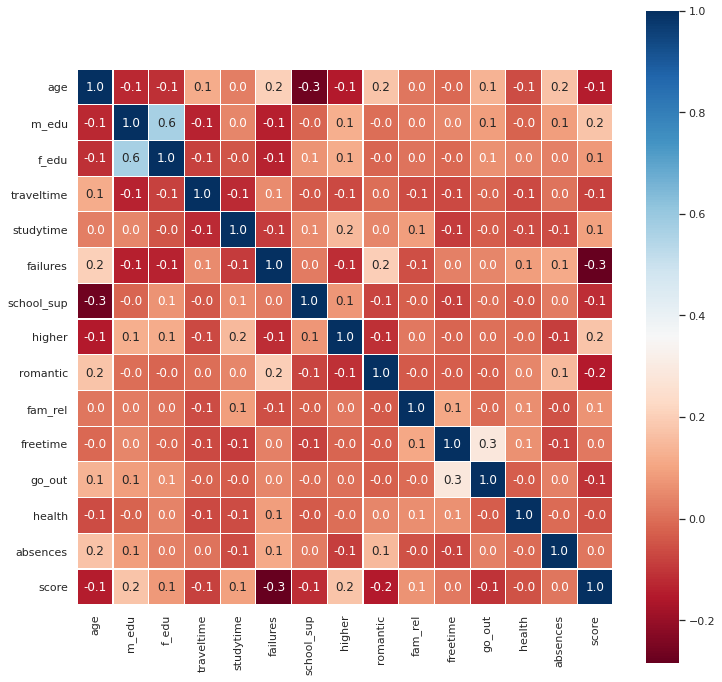

In [447]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(smath.corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [448]:
smath.drop(columns=['f_edu'], inplace=True) # сильно скоррелированное значение с m_edu
smath = pd.get_dummies(smath) # преобразуем категориальные значения в dummy переменные

In [455]:
standardized_smath = smath.copy()

scaler = StandardScaler()
scaler.fit(smath[['age', 'm_edu', 'traveltime', 'studytime', 'failures', 'fam_rel',
                  'freetime', 'go_out', 'health', 'absences', 'score']])
standardized_smath[['age', 'm_edu', 'traveltime', 'studytime', 'failures', 'fam_rel', 
                             'freetime', 'go_out', 'health', 'absences', 'score']] = scaler.transform(smath[['age', 'm_edu', 'traveltime', 'studytime', 'failures', 'fam_rel', 'freetime', 'go_out', 'health', 'absences', 'score']])

In [449]:
smath # финальный датасет

,age,m_edu,traveltime,studytime,failures,school_sup,higher,romantic,fam_rel,freetime,go_out,health,absences,score,sex_F,sex_M,address_R,address_U,m_job_at_home,m_job_health,m_job_other,m_job_services,m_job_teacher
0,18,4.0,2.0,2.0,0.0,1,1,0,4.0,3.0,4.0,3.0,6.0,30.0,1,0,0,1,1,0,0,0,0
1,17,1.0,1.0,2.0,0.0,0,1,0,5.0,3.0,3.0,3.0,4.0,30.0,1,0,0,1,1,0,0,0,0
3,15,4.0,1.0,3.0,0.0,0,1,1,3.0,2.0,2.0,5.0,2.0,75.0,1,0,0,1,0,1,0,0,0
4,16,3.0,1.0,2.0,0.0,0,1,0,4.0,3.0,2.0,5.0,4.0,50.0,1,0,0,1,0,0,1,0,0
5,16,4.0,1.0,2.0,0.0,0,1,0,5.0,4.0,2.0,5.0,10.0,75.0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,19,2.0,1.0,3.0,1.0,0,1,0,5.0,4.0,2.0,5.0,0.0,0.0,1,0,1,0,0,0,0,1,0
388,18,3.0,1.0,2.0,0.0,0,1,0,4.0,3.0,4.0,1.0,0.0,40.0,1,0,0,1,0,0,0,0,1
391,17,3.0,2.0,1.0,0.0,0,1,0,2.0,4.0,5.0,2.0,3.0,80.0,0,1,0,1,0,0,0,1,0
393,18,3.0,3.0,1.0,0.0,0,1,0,4.0,4.0,1.0,5.0,0.0,50.0,0,1,1,0,0,0,0,1,0


In [456]:
standardized_smath # финальный стандартизированный датасет

,age,m_edu,traveltime,studytime,failures,school_sup,higher,romantic,fam_rel,freetime,go_out,health,absences,score,sex_F,sex_M,address_R,address_U,m_job_at_home,m_job_health,m_job_other,m_job_services,m_job_teacher
0,1.100065,1.112969,1.064860,-0.072343,-0.422954,1,1,0,-0.007284,-0.216754,0.856793,-0.409068,0.038332,-1.026112,1,0,0,1,1,0,0,0,0
1,0.280057,-1.683461,-0.629657,-0.072343,-0.422954,0,1,0,1.325680,-0.216754,-0.082088,-0.409068,-0.207798,-1.026112,1,0,0,1,1,0,0,0,0
3,-1.359958,1.112969,-0.629657,1.131187,-0.422954,0,1,1,-1.340248,-1.247037,-1.020969,1.051603,-0.453927,0.972713,1,0,0,1,0,1,0,0,0
4,-0.539950,0.180826,-0.629657,-0.072343,-0.422954,0,1,0,-0.007284,-0.216754,-1.020969,1.051603,-0.207798,-0.137745,1,0,0,1,0,0,1,0,0
5,-0.539950,1.112969,-0.629657,-0.072343,-0.422954,0,1,0,1.325680,0.813530,-1.020969,1.051603,0.530591,0.972713,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1.920072,-0.751317,-0.629657,1.131187,1.613903,0,1,0,1.325680,0.813530,-1.020969,1.051603,-0.700057,-2.358663,1,0,1,0,0,0,0,1,0
388,1.100065,0.180826,-0.629657,-0.072343,-0.422954,0,1,0,-0.007284,-0.216754,0.856793,-1.869738,-0.700057,-0.581929,1,0,0,1,0,0,0,0,1
391,0.280057,0.180826,1.064860,-1.275874,-0.422954,0,1,0,-2.673212,0.813530,1.795675,-1.139403,-0.330863,1.194805,0,1,0,1,0,0,0,1,0
393,1.100065,0.180826,2.759378,-1.275874,-0.422954,0,1,0,-0.007284,0.813530,-1.959851,1.051603,-0.700057,-0.137745,0,1,1,0,0,0,0,1,0
